# multiclass classification example - SF crime dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import dill
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
import treelite
import treelite_runtime
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

**Gators** imports

In [4]:
from gators.util import util
# data cleaning
from gators.data_cleaning import (
    ConvertColumnDatatype,
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    WOEEncoder, 
    TargetEncoder,
    OrdinalEncoder,
)
# binning
from gators.binning import (
    BinRareCategories,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
    PolynomialObjectFeatures,
    ElementaryArithmetics,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
from gators.feature_generation_dt import (
    CyclicHourOfDay,
    CyclicDayOfMonth,
    CyclicDayOfWeek,
    CyclicMonthOfYear,
    OrdinalDayOfMonth,
    OrdinalMonthOfYear,
    OrdinalDayOfWeek,
    OrdinalHourOfDay,
)
# feature selection
from gators.feature_selection import (
    InformationValue,
)
# feature generation
from gators.feature_generation import PlaneRotation
# model building
from gators.model_building import (
    TrainTestSplit,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
    LGBMTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## data analysis

In [5]:
data = pd.read_parquet('data/sf_crime.parquet')
data = data.reset_index(drop=True)
y = data['Category']
X = data.drop(['Category'], axis=1)
# ordinal target
classes = y.unique()
target_mapping = dict(zip(classes, range(len(classes))))
y = y.replace(target_mapping)
# train test split
train_test_split = TrainTestSplit(test_ratio=0.3, strategy='stratified')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
# one-hot target
target_mapping_ = {v: k for k, v in target_mapping.items()}
y_train_dummies = pd.get_dummies(y_train.replace(target_mapping_))
y_test_dummies = pd.get_dummies(y_test.replace(target_mapping_))

In [6]:
X_train.head(2)

,Dates,PdDistrict,Address,X,Y
4227,2010-03-24 12:35:00,SOUTHERN,0 Block of DORE ST,-122.412933,37.773927
6326,2007-09-07 18:00:00,INGLESIDE,200 Block of ADDISON ST,-122.432398,37.737822


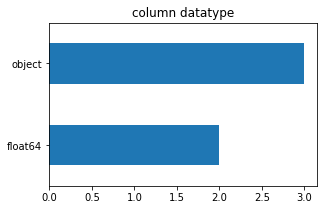

In [7]:
X_train.dtypes.value_counts(ascending=True).plot(
    figsize=(3*1.6, 3), 
    kind='barh', 
    title='column datatype',
);

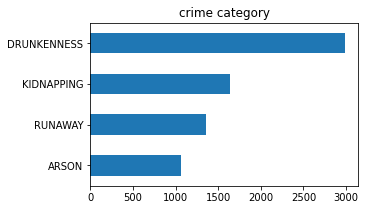

In [8]:
# target analysis
target_count = y_train.value_counts()
target_count.index = [target_mapping_[i] for i in target_count.index]
target_count.iloc[::-1].plot(
    title='crime category',
    figsize=(3*1.6, 3), 
    kind='barh');

In [9]:
steps = [
    ('ConvertColumnDatatype', ConvertColumnDatatype(
        columns=['Dates'], datatype='datetime64[ns]')),
    ('OrdinalHourOfDay', OrdinalHourOfDay(columns=['Dates'])),
    ('OrdinalDayOfWeek', OrdinalDayOfWeek(columns=['Dates'])),
    ('OrdinalDayOfMonth', OrdinalDayOfMonth(columns=['Dates'])),
    ('OrdinalMonthOfYear', OrdinalMonthOfYear(columns=['Dates'])),
    ('CyclicHourOfDay', CyclicHourOfDay(columns=['Dates'])),
    ('CyclicDayOfWeek', CyclicDayOfWeek(columns=['Dates'])),
    ('CyclicDayOfMonth', CyclicDayOfMonth(columns=['Dates'])),
    ('CyclicMonthOfYear', CyclicMonthOfYear(columns=['Dates'])),
    ('StringContains', StringContains(
        columns=['Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet'])),
    ('DropColumns', DropColumns(columns=['Dates', 'Address'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=300),
        inplace=True)),
    ('CleanCategories', BinRareCategories(min_ratio=0.01)),
    ('Encoder', TargetEncoder()),
]
pipe = Pipeline(steps=steps)

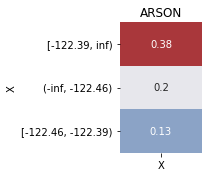

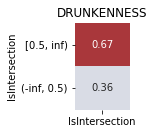

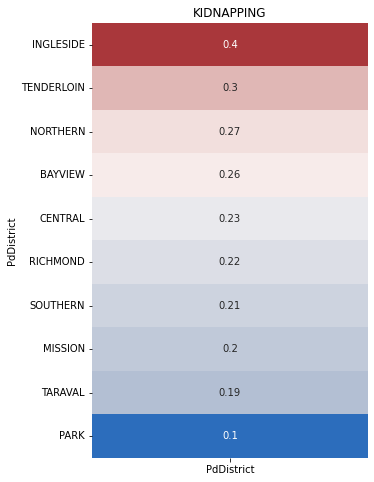

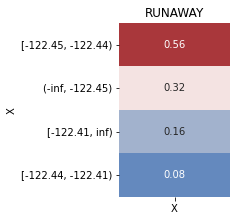

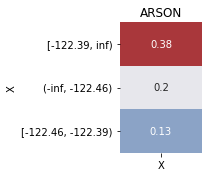

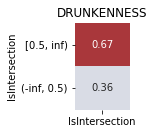

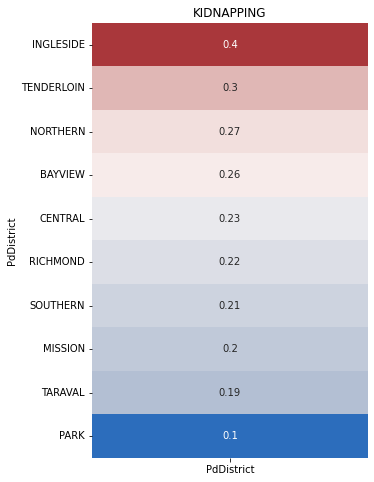

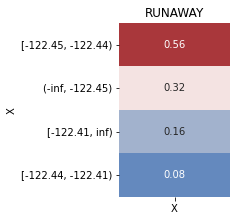

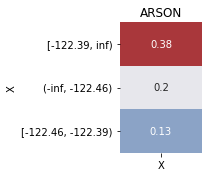

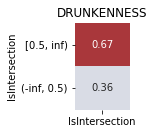

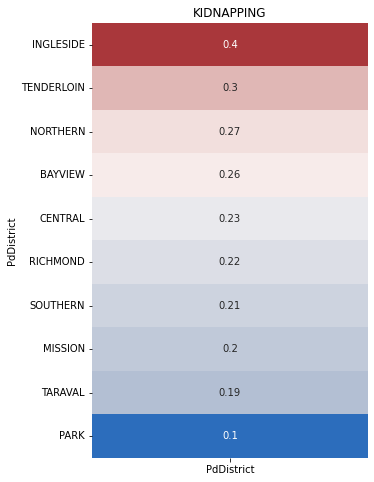

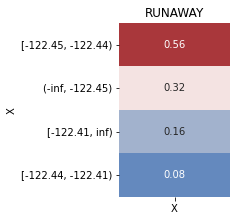

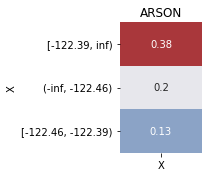

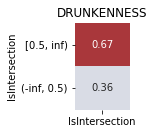

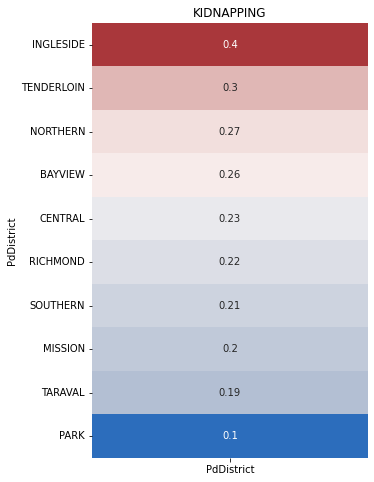

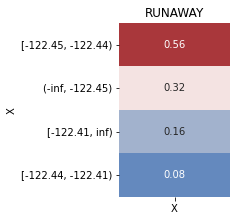

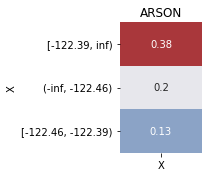

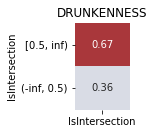

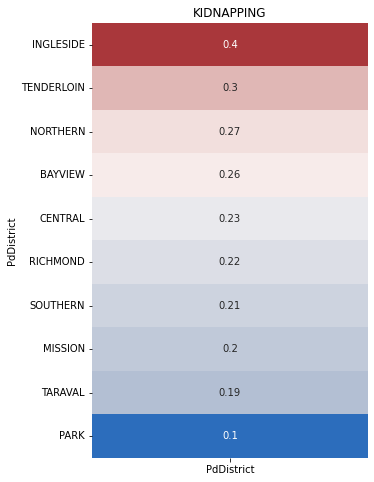

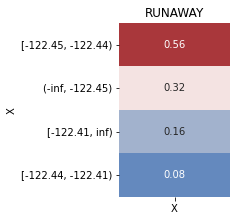

In [10]:
for c in X_train.columns:
    for i, name in enumerate(y_train_dummies.columns):
        _ = pipe.fit(X_train.copy(), y_train_dummies[name])
        pipe.steps[-1][1].display_mapping(cmap='vlag', k=1, title=name)

#### adding polynomial object features

In [11]:
steps = [
    ('ConvertColumnDatatype', ConvertColumnDatatype(
        columns=['Dates'], datatype='datetime64[ns]')),
    ('OrdinalHourOfDay', OrdinalHourOfDay(columns=['Dates'])),
    ('OrdinalDayOfWeek', OrdinalDayOfWeek(columns=['Dates'])),
    ('OrdinalDayOfMonth', OrdinalDayOfMonth(columns=['Dates'])),
    ('OrdinalMonthOfYear', OrdinalMonthOfYear(columns=['Dates'])),
    ('CyclicHourOfDay', CyclicHourOfDay(columns=['Dates'])),
    ('CyclicDayOfWeek', CyclicDayOfWeek(columns=['Dates'])),
    ('CyclicDayOfMonth', CyclicDayOfMonth(columns=['Dates'])),
    ('CyclicMonthOfYear', CyclicMonthOfYear(columns=['Dates'])),
    ('StringContains', StringContains(
        columns=['Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet'])),
    ('DropColumns', DropColumns(columns=['Dates', 'Address'])),
    ('PlaneRotation', PlaneRotation(
    columns= [['X','Y']], 
    theta_vec= [15, 30, 45])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=300),
        inplace=True)),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=[
            'PdDistrict', 'X', 'Y', 'Dates__hour_of_day', 'Dates__day_of_week', 
            'Dates__day_of_month'],
        degree=2)),
    ('CleanCategories', BinRareCategories(min_ratio=0.05)),
    ('Encoder', TargetEncoder()),
]

pipe = Pipeline(steps=steps, verbose=False)

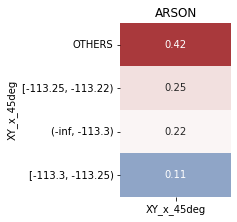

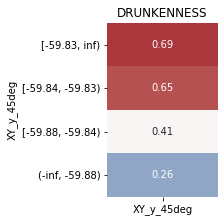

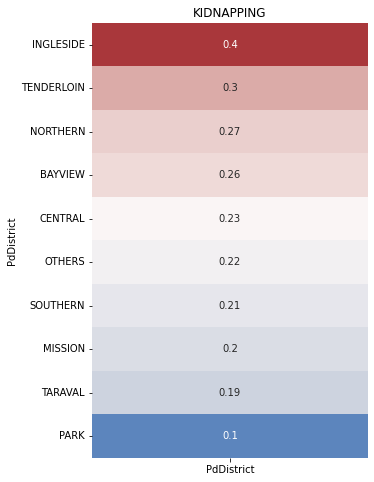

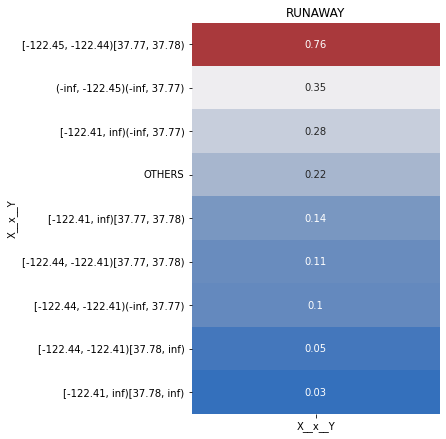

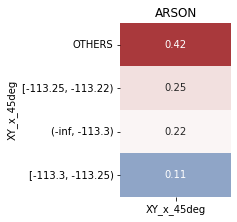

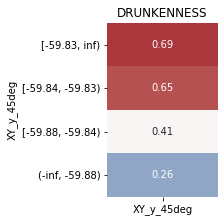

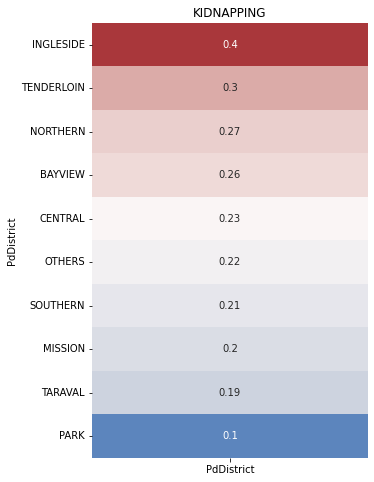

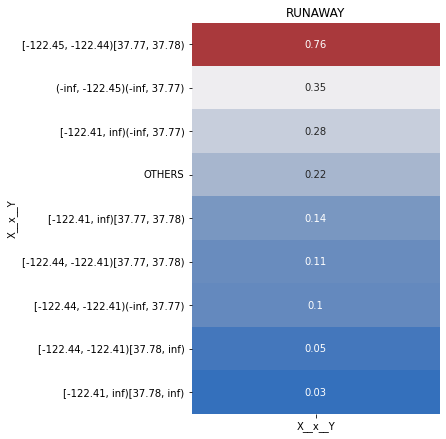

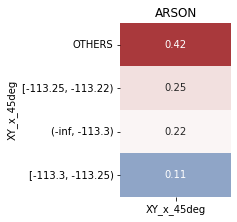

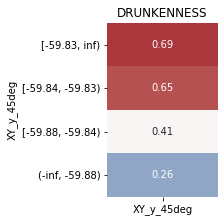

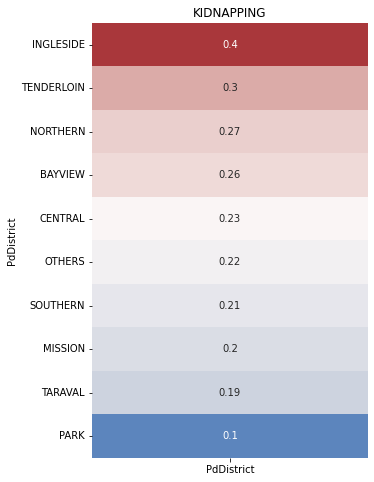

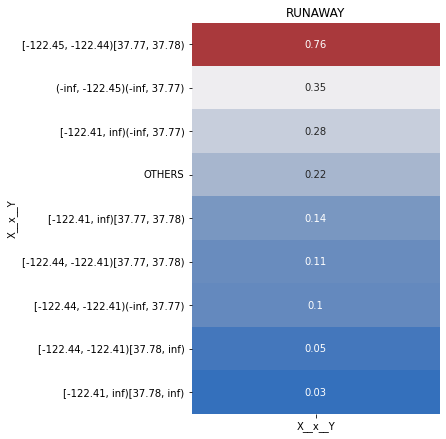

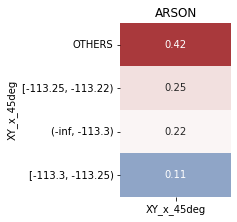

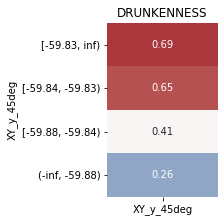

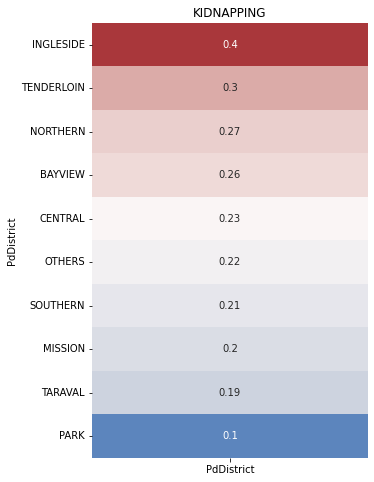

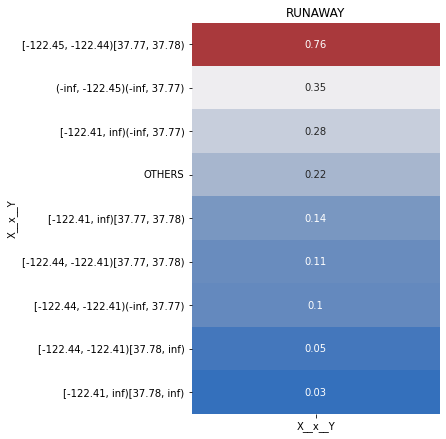

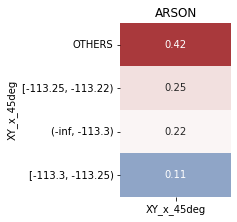

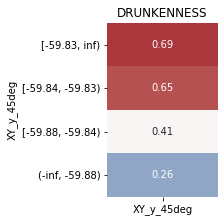

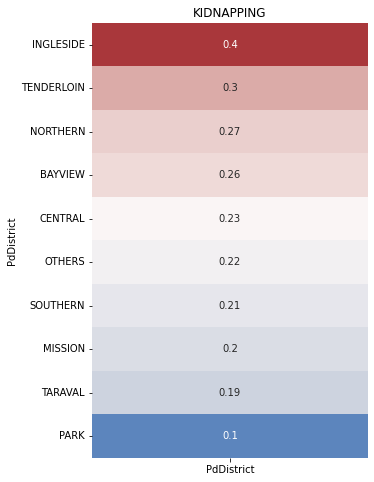

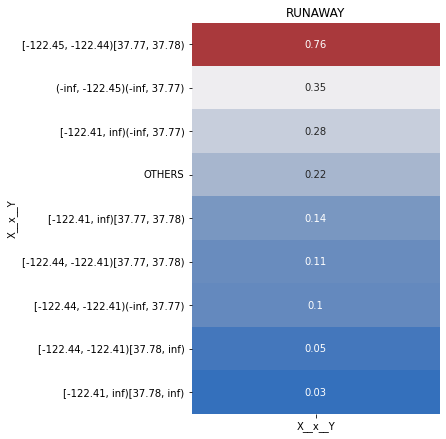

In [12]:
for c in X_train.columns:
    for i, name in enumerate(y_train_dummies.columns):
        _ = pipe.fit(X_train.copy(), y_train_dummies[name])
        pipe.steps[-1][1].display_mapping(cmap='vlag', k=1, title=name)

## offline pipeline - feature selection

In [13]:
steps = [
    ('ConvertColumnDatatype', ConvertColumnDatatype(columns=['Dates'], datatype='datetime64[ns]')),
    ('OrdinalHourOfDay', OrdinalHourOfDay(columns=['Dates'])),
    ('OrdinalDayOfWeek', OrdinalDayOfWeek(columns=['Dates'])),
    ('OrdinalDayOfMonth', OrdinalDayOfMonth(columns=['Dates'])),
    ('OrdinalMonthOfYear', OrdinalMonthOfYear(columns=['Dates'])),
    ('CyclicHourOfDay', CyclicHourOfDay(columns=['Dates'])),
    ('CyclicDayOfWeek', CyclicDayOfWeek(columns=['Dates'])),
    ('CyclicDayOfMonth', CyclicDayOfMonth(columns=['Dates'])),
    ('CyclicMonthOfYear', CyclicMonthOfYear(columns=['Dates'])),
    ('StringContains', StringContains(
        columns=['Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet'])),
    ('DropColumns', DropColumns(columns=['Dates', 'Address'])),
    ('PlaneRotation', PlaneRotation(
    columns=[['X','Y']], 
    theta_vec= [15, 30, 45])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=300),
        inplace=True)),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=[
            'PdDistrict', 'X', 'Y', 'XY_y_45deg', 'Dates__hour_of_day', 'Dates__day_of_week', 
            'Dates__day_of_month'],
        degree=2)),
    ('CleanCategories', BinRareCategories(min_ratio=0.05)),
    ('InformationValue', InformationValue(k=20, max_iv=50))
]

pipe = Pipeline(steps=steps, verbose=False)

In [14]:
feature_importances_dummy = []
for i, name in enumerate(y_train_dummies.columns):
    _ = pipe.fit(X_train.copy(), y_train_dummies[name])
    feature_importances_dummy.append(pipe.steps[-1][1].feature_importances_)
feature_importances_ = pd.concat(
    feature_importances_dummy, axis=1).fillna(0).rename(columns=target_mapping_)
feature_importances_['sum'] = feature_importances_.sum(1)
feature_importances_ = feature_importances_.sort_values('sum', ascending=False)

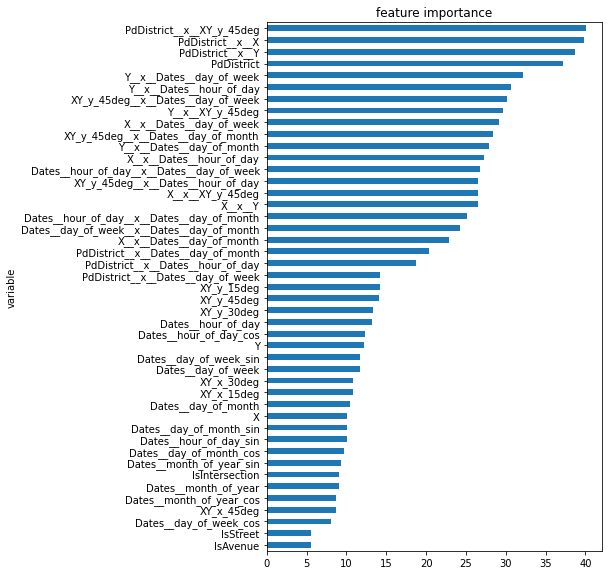

In [15]:
feature_importances_['sum'].sort_values().plot(
    kind='barh', 
    figsize=(6, 6 * 1.62), 
    title='feature importance',
);

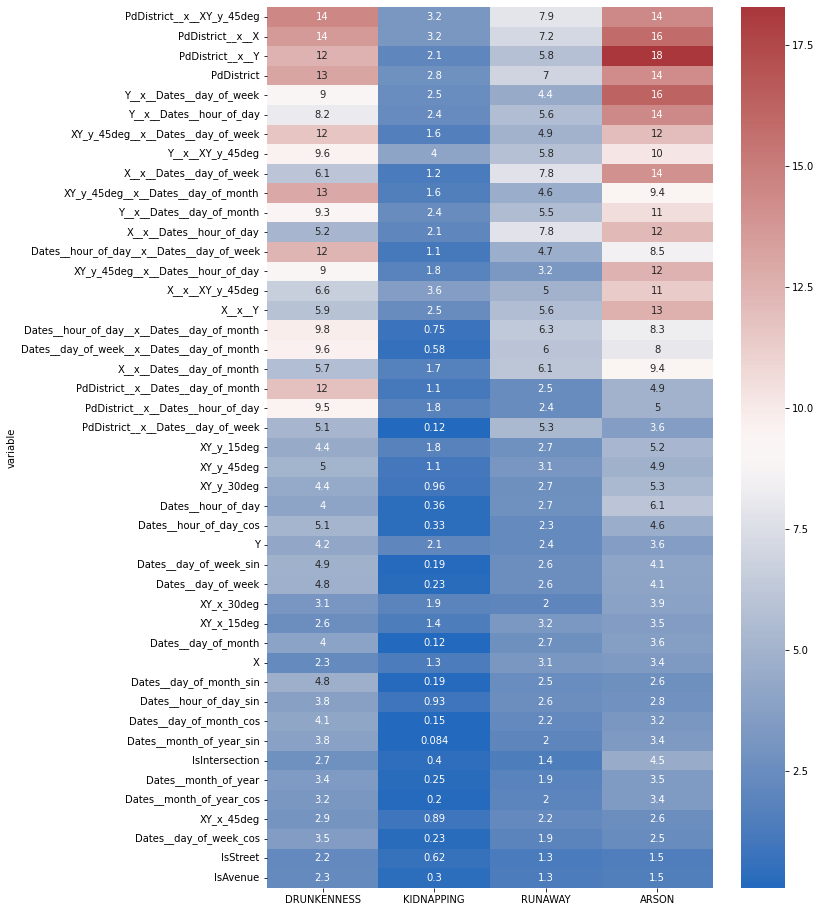

In [16]:
fig, ax = plt.subplots(figsize=(10, 10* 1.62))
sns.heatmap(feature_importances_.drop('sum', axis=1), ax=ax, cmap=cmap, annot=True);

All the features will be used.


## pipeline optimization

In [17]:
steps = [
    ('ConvertColumnDatatype', ConvertColumnDatatype(columns=['Dates'], datatype='datetime64[ns]')),
    ('OrdinalHourOfDay', OrdinalHourOfDay(columns=['Dates'])),
    ('OrdinalDayOfWeek', OrdinalDayOfWeek(columns=['Dates'])),
    ('OrdinalDayOfMonth', OrdinalDayOfMonth(columns=['Dates'])),
    ('OrdinalMonthOfYear', OrdinalMonthOfYear(columns=['Dates'])),
    ('CyclicHourOfDay', CyclicHourOfDay(columns=['Dates'])),
    ('CyclicDayOfWeek', CyclicDayOfWeek(columns=['Dates'])),
    ('CyclicDayOfMonth', CyclicDayOfMonth(columns=['Dates'])),
    ('CyclicMonthOfYear', CyclicMonthOfYear(columns=['Dates'])),
    ('StringContains', StringContains(
        columns=['Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet'])),
    ('DropColumns', DropColumns(columns=['Dates', 'Address'])),
    ('PlaneRotation', PlaneRotation(
    columns=[['X','Y']], 
    theta_vec= [15, 30, 45])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=300),
        inplace=True)),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=[
            'PdDistrict', 'X', 'Y', 'XY_y_45deg', 'Dates__hour_of_day', 'Dates__day_of_week', 
            'Dates__day_of_month'],
        degree=2)),
    ('CleanCategories', BinRareCategories(min_ratio=0.05)),
    ('Encoder', WOEEncoder()),
    ('ESTIMATOR', XGBClassifier(random_state=0, eval_metric='logloss', use_label_encoder=False))
]

param_distributions = {
    "PlaneRotation__theta_vec": [
        [15, 30, 45], [5, 10, 15, 20, 25, 30, 40, 45]],
    "TreeBinning__tree": [
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=100, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=3, 
            min_samples_leaf=100, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=200, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=3, 
            min_samples_leaf=200, 
            random_state=0),
    ],
    'ESTIMATOR__max_depth': [2, 3, 4],
    'ESTIMATOR__subsample': [0.2, 0.3, 0.4],
    'ESTIMATOR__colsample_bytree': [0.4, 0.6, .8],
    'ESTIMATOR__colsample_bylevel': [0.4, 0.6, .8],
    'ESTIMATOR__min_child_weight': [10, 20, 30],
}
def f1_score_binary(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)
f1_scoring = make_scorer(f1_score_binary)

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
pipe = Pipeline(steps=steps)
search = RandomizedSearchCV(
    Pipeline(steps=steps),
    param_distributions=param_distributions, 
    n_iter=10,
    cv=cv,
    n_jobs=-1,
    random_state=0,
    verbose=True)

In [18]:
pipe_dict = {}
for name in y_train_dummies.columns:
    print(name, end=': ')
    _ = search.fit(X_train.copy(), y_train_dummies[name])
    pipe_dict[name] = copy.deepcopy(search.best_estimator_)

ARSON: Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with

DRUNKENNESS: Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be rem

KIDNAPPING: Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be rem

RUNAWAY: Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be rem

## model evaluation

In [19]:
y_train_pred_proba = pd.DataFrame(index=y_train.index, dtype=float)
y_test_pred_proba = pd.DataFrame(index=y_test.index, dtype=float)
thresholds = np.linspace(0, 1, 25)[1:-1]
for name, pipe in pipe_dict.items():
    y_train_pred_proba[name] = pipe.predict_proba(X_train.copy())[:, 1]
    y_test_pred_proba[name] = pipe.predict_proba(X_test.copy())[:, 1]

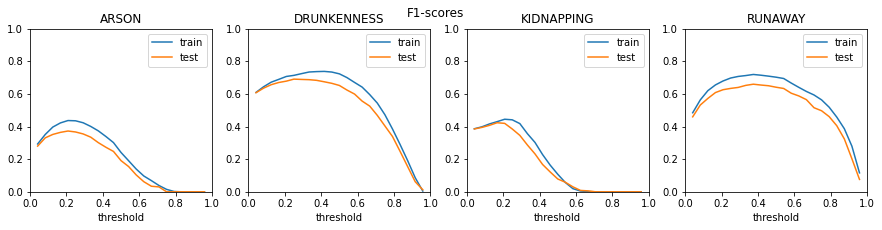

In [20]:
fig, ax = plt.subplots(1, 4, figsize=[15, 3]);
for i, (name, pipe) in enumerate(pipe_dict.items()):
    fscores_train = [
        f1_score_binary(y_train_dummies[name], y_train_pred_proba[name] > t) 
        for t in thresholds]
    fscores_test = [
        f1_score_binary(y_test_dummies[name], y_test_pred_proba[name] > t) 
        for t in thresholds]
    _ = ax[i].set_ylim(0, 1.);    
    _ = ax[i].set_xlim(0, 1.);
    _ = ax[i].set_title(f'{name}')
    _ = ax[i].set_xlabel('threshold');
    _ = ax[i].plot(thresholds, fscores_train, label='train');
    _ = ax[i].plot(thresholds, fscores_test, label='test');
    _ = ax[i].legend()
_ = plt.suptitle('F1-scores')

In [21]:
print('Total F1-score')
f1_train = f1_score(
    y_train,
    y_train_pred_proba.idxmax(1).replace(target_mapping),
    average="micro")
print(f'f1 score - train: {f1_train:.2f}')
f1_test = f1_score(
    y_test,
    y_test_pred_proba.idxmax(1).replace(target_mapping),
    average="micro")
print(f'f1 score - test: {f1_test:.2f}')

Total F1-score
f1 score - train: 0.62
f1 score - test: 0.56


## production pipeline & model

In [22]:
prod_pipe_dict = {}
model_pd_dict = {}

search_ = copy.deepcopy(search)
for name, pipe in pipe_dict.items():
    model_pd_dict[name] = copy.deepcopy(pipe.steps[-1][1])
    _ = pipe.steps.pop(-1)
    prod_pipe_dict[name] = copy.deepcopy(pipe)

In [23]:
model_prod_dict = {}
for i, (name, prod_pipe) in enumerate(prod_pipe_dict.items()):

    X_train_prepro_np = prod_pipe.transform_numpy(X_train.copy().to_numpy())
    y_train_np = y_train_dummies[name].to_numpy()

    xgb_booster = XGBBoosterBuilder.train(
        model=model_pd_dict[name], 
        X_train=X_train_prepro_np, 
        y_train=y_train_np,
    )

    treelite_model = treelite.Model.from_xgboost(xgb_booster)
    treelite_model.export_lib(
        toolchain='gcc', 
        libpath=f'./models/treelite_xgb_sfcrime_{i}.so', 
        params={'parallel_comp': 4},
        verbose=False
    )
    model_prod_dict[name] = treelite_runtime.Predictor(
        f'./models/treelite_xgb_sfcrime_{i}.so', verbose=False)

[16:55:53] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[16:55:55] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[16:55:57] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[16:56:00] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.


### check if Pandas & Treelite predictions match

In [24]:
X_test_np = X_test.to_numpy()

for i, (name, prod_pipe) in enumerate(prod_pipe_dict.items()):
    y_pred_pd = model_pd_dict[name].predict_proba(
        prod_pipe.transform(X_test.copy()))[:, 1]

    y_pred_tl = model_prod_dict[name].predict(
        treelite_runtime.DMatrix(
            prod_pipe.transform_numpy(
                X_test_np.copy()
            )
        )
    )
    assert np.allclose(y_pred_pd, y_pred_tl)

## per-sample bechmarking

### pipeline only

In [25]:
x = X_test.iloc[[0]]
x_np = x.to_numpy()
preds = np.zeros(4)

In [26]:
%%timeit
for i, (name, prod_pipe) in enumerate(prod_pipe_dict.items()):
    _ = prod_pipe.transform(x.copy())

1.1 s ± 86.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
for i, (name, prod_pipe) in enumerate(prod_pipe_dict.items()):
    _ = prod_pipe.transform_numpy(x_np.copy())

1.33 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Speed-up Pandas VS Numpy x986

### pipeline & model

In [28]:
%%timeit
for i, (name, prod_pipe) in enumerate(prod_pipe_dict.items()):
    preds[i] = model_pd_dict[name].predict_proba(
        prod_pipe.transform(x.copy()))[:, 1]
np.argmax(preds)

1.42 s ± 409 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit

for i, (name, prod_pipe) in enumerate(prod_pipe_dict.items()):
    preds[i] = model_prod_dict[name].predict(
        treelite_runtime.DMatrix(
            prod_pipe.transform_numpy(
                x_np.copy()
            )
        )
    )
np.argmax(preds)

2.82 ms ± 597 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Speed-up Pandas VS Numpy x762